In [1]:
#!nvidia-smi

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import sys
import re
from pathlib import Path
import gc
import tqdm
import json
import yadisk
import numpy as np
import pandas as pd
import mediapy as media
from datetime import timedelta
import cv2
from IPython.display import clear_output, display, Video
from PIL import Image
import pytesseract

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms 
from torch import nn
from diffusers import LDMSuperResolutionPipeline
import supervision as sv

import matplotlib.pyplot as plt
import matplotlib.patches as patches

np.random.seed(12345)
torch.manual_seed(12345)
torch.cuda.manual_seed(12345)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
y = yadisk.YaDisk(token='...')

In [3]:
HOCKEY_LIST = ['hockey', 'ice', 'stick', 'puck', 'goal', 'goalie', 'net', 'skate', 'rink', 'team', 'player', 'referee',
'penalty', 'power play', 'faceoff', 'slapshot', 'wrist shot', 'body check', 'hat trick', 'overtime', 'shootout', ]

In [4]:
def imshow_frame(inp, title=None, plt_ax=plt,  mode=None, color = None, pil=None):
    if mode=='tensor':
        inp = inp.numpy().transpose((1, 2, 0))
        inp = np.clip(inp, 0, 1)
        plt_ax.imshow(inp, 'gray')
    else:
        if pil is None:
            plt_ax.imshow(inp, cmap=color)
        else:
            inp_RGB = cv2.cvtColor(inp, cv2.COLOR_BGR2RGB)
            plt_ax.imshow(inp_RGB, cmap=color)
    try:
        if title is not None:
            plt_ax.set_title(title)
    except:
        plt.title(title)
    plt_ax.grid(False)

## Загрузка

In [ ]:
#yadisk-direct
! curl -La $(yadisk-direct https://disk.yandex.ru/i/boGrKW9xgCa_9g) -o test.mp4

In [16]:
#yadisk
url = y.get_public_download_link('https://disk.yandex.ru/d/Z3gCirxxGcoDRA', path='/снежинка/29/fleshmp4 - 29 апреля 2023 - 10-50-57 .mp4')
y.download_by_link(url, 'test_6.mp4')

## Kонвертации

In [ ]:
#ffmpeg converter to 720x406 with cfr=20
# !ffmpeg -i data/output/for_numbers/vid_3.mp4 -crf 20 -vf scale=720:-2 -y data/output/output_ffmpeg_sitting.mp4
!ffmpeg -i test_3.mp4 -crf 20 -vf scale=720:-2 -y data/output/for_numbers/test_3_s.mp4

## Получение текстового описания кадров

BLIP: Bootstrapping Language-Image Pre-training for Unified Vision-Language Understanding and Generation вроде ок

In [5]:
file = '/home/eugene/develop/adaptive_hockey/convert/2024-03-31_0.mp4'

In [6]:
cap = cv2.VideoCapture(file)

In [7]:
from transformers import BlipProcessor, BlipForConditionalGeneration

processor = BlipProcessor.from_pretrained('Salesforce/blip-image-captioning-base')
model = BlipForConditionalGeneration.from_pretrained('Salesforce/blip-image-captioning-base').to(device)

In [8]:
def predict_step(frames):
    inputs = processor(frames, text='', return_tensors='pt')
    inputs = inputs.to(device)
    out = model.generate(**inputs)
    preds = processor.decode(out[0], skip_special_tokens=True)
    return preds

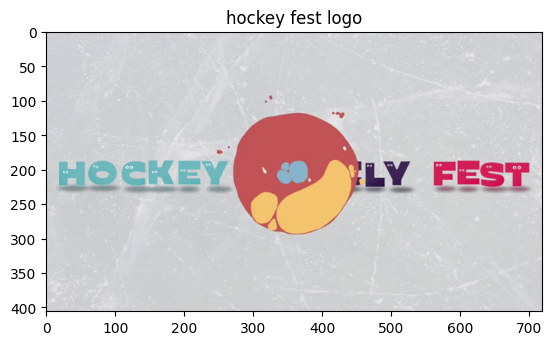

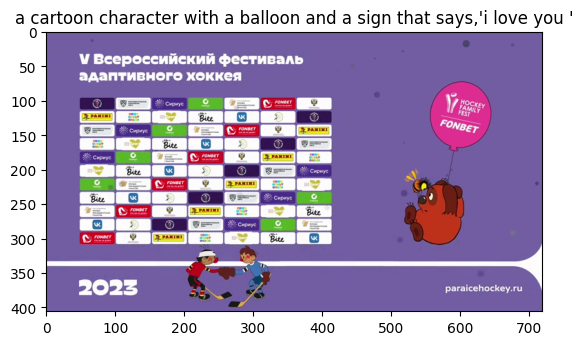

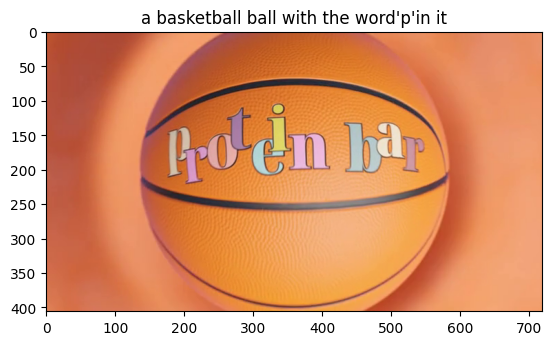

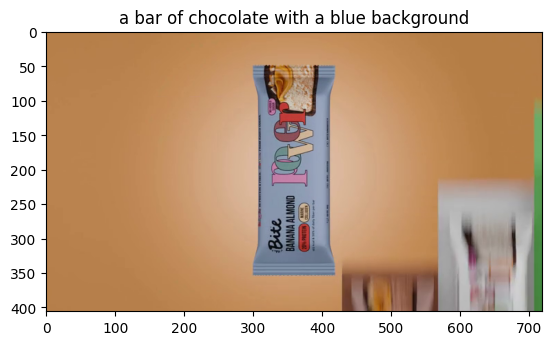

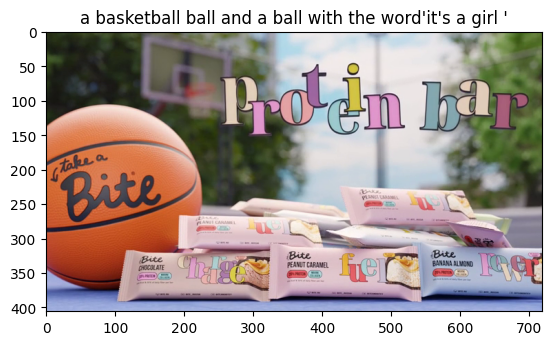

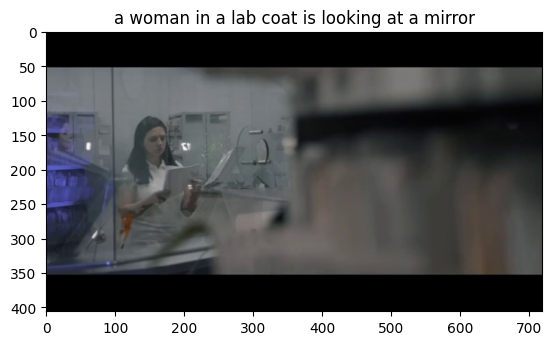

In [9]:
for i in range(500, 2000, 250):
    cap.set(cv2.CAP_PROP_POS_FRAMES,i-1)
    _, frame = cap.read()
    title = predict_step(frame)
    imshow_frame(frame, title, pil='yes')
    plt.show()

## Обрезка видео

In [13]:
class Hockey:
    def __init__(self, file, dir=None):
        self.cap = cv2.VideoCapture(file)
        self.filename = os.path.basename(file).split('.')[0]
        self.fps = int(self.cap.get(cv2.CAP_PROP_FPS))
        self.count_frames = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.dir = dir

    def get_label(self, text):
        if ('hockey' in text) or (len([word for word in text.split() if word in HOCKEY_LIST])>0):
            return 1
        return 0

    def get_frame(self, i):
        self.cap.set(cv2.CAP_PROP_POS_FRAMES,i-1)
        _, frame = self.cap.read()
        return frame

    def get_text(self, frame):
        inputs = processor(frame, text='', return_tensors='pt')
        inputs = inputs.to(device)
        out = model.generate(**inputs)
        text = processor.decode(out[0], skip_special_tokens=True)
        return text

    def get_result(self, item):
        frame = self.get_frame(item)
        text = self.get_text(frame)
        label = self.get_label(text)
        if self.dir is not None:
            cv2.imwrite(dir+f'{self.filename}_{item-1}.jpg', frame)
        return [f'{self.filename}_{item-1}.jpg', item-1, text, label], label


In [14]:
game = Hockey(file)

In [15]:
def get_info_about_game(game):
    info_list = []
    last_value = 0
    time = 10
    for i in tqdm.tqdm(range(game.fps*time, game.count_frames, game.fps*time)):
        result, label = game.get_result(i)
        if label!=last_value:
            y=i-250
            while y>i-game.fps*time:
                result, lbl = game.get_result(y)
                y-=250
                info_list.append(result)
        else:
            info_list.append(result)
        last_value = label
    info_list  = sorted(info_list, key = lambda x:x[1])
    return info_list

In [16]:
%%time
game_info = get_info_about_game(game)

100%|██████████| 513/513 [01:47<00:00,  4.76it/s]

CPU times: user 4min 58s, sys: 5.43 s, total: 5min 3s
Wall time: 1min 47s


In [17]:
pd.DataFrame(game_info, columns = ['file', 'frame', 'text', 'label']).head(20)

file  frame  \
0    2024-03-31_0_499.jpg    499   
1    2024-03-31_0_999.jpg    999   
2   2024-03-31_0_1249.jpg   1249   
3   2024-03-31_0_1499.jpg   1499   
4   2024-03-31_0_1749.jpg   1749   
5   2024-03-31_0_1999.jpg   1999   
6   2024-03-31_0_2249.jpg   2249   
7   2024-03-31_0_2499.jpg   2499   
8   2024-03-31_0_2749.jpg   2749   
9   2024-03-31_0_2999.jpg   2999   
10  2024-03-31_0_3249.jpg   3249   
11  2024-03-31_0_3499.jpg   3499   
12  2024-03-31_0_3749.jpg   3749   
13  2024-03-31_0_3999.jpg   3999   
14  2024-03-31_0_4249.jpg   4249   
15  2024-03-31_0_4499.jpg   4499   
16  2024-03-31_0_4749.jpg   4749   
17  2024-03-31_0_4999.jpg   4999   
18  2024-03-31_0_5249.jpg   5249   
19  2024-03-31_0_5499.jpg   5499   

                                                 text  label  
0                                    hockey fest logo      1  
1             a basketball ball with the word'p'in it      0  
2           a bar of chocolate with a blue background      0  
3   a basketball ball and a ball with the word'it'...      0  
4        a woman in a lab coat is looking at a mirror      0  
5               a person in gloves is using a machine      0  
6       a man holding a microphone in front of a wall      0  
7   a man is getting his body painted with a paint...      0  
8   a woman in a blue dress standing in front of a...      0  
9          a man in a brown shirt is using a computer      0  
10             a computer screen with a message on it      0  
11                         the logo for the golf club      0  
12          a blue background with many small bubbles      0  
13              a glass of milk next to a box of milk      0  
14  the view from the top of a building with trees...      0  
15                         a man in a lab with a pipe      0  
16                 two men looking at a laptop screen      0  
17         a laptop computer sitting on top of a desk      0  
18               a machine that is sitting on a table      0  
19            a display case with a white dress on it      0

In [18]:
def get_index_for_game(info_list):
    last_value=info_list[0][-1]
    x = info_list[0][1]
    coord = []
    for i in range(len(info_list)):
        if info_list[i][-1]!=last_value or i==len(info_list)-1:
            y=info_list[i][1]
            coord.append([last_value, x,y])
            x,last_value = y,info_list[i][-1]
    game_coord = list(filter(lambda x: x[0]==1, coord))
    return game_coord

In [19]:
game_coord = get_index_for_game(game_info)
list_frame = []
for i in range(len(game_coord)):
    list_frame.extend([y for y in range(game_coord[i][1], game_coord[i][-1]+1)])

len(list_frame)

105759

In [20]:
game_coord

[[1, 499, 999],
 [1, 6999, 7999],
 [1, 8499, 34499],
 [1, 35999, 63249],
 [1, 63749, 104749],
 [1, 105249, 107249],
 [1, 109249, 116249],
 [1, 116749, 117249],
 [1, 125749, 126249]]

In [21]:
def write_new_file(input_file, output_file):
    cap = cv2.VideoCapture(input_file)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc('X','V','I','D')
    output = cv2.VideoWriter(output_file, fourcc, fps, (width, height))

    return cap, output       

In [23]:
%%time
output_file = 'data/output/clear_game.mp4'
cap, output = write_new_file(file, output_file)
cap.set(cv2.CAP_PROP_POS_FRAMES, list_frame[0])

for i, fr in enumerate(list_frame):
    if fr-1!=list_frame[i-1] or i==0:
        cap.set(cv2.CAP_PROP_POS_FRAMES, fr)
    _, frame = cap.read()
    output.write(frame)

output.release()
cap.release()

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


CPU times: user 7min 38s, sys: 1.29 s, total: 7min 40s
Wall time: 4min 33s


## Детекция

In [20]:
%cd /home/eugene/develop/yolov7-object-tracking

/home/eugene/develop/yolov7-object-tracking


In [ ]:
%%time

!python detect_and_track.py --weights yolov7.pt --source '/home/eugene/develop/data/output/clear_game.mp4' \
--classes 0 --save-with-object-id --save-bbox-dim --save-txt --device 0  --no-trace

In [ ]:
video = media.read_video('/home/eugene/develop/yolov7-object-tracking/runs/detect/object_tracking19/clear_game.mp4')
media.show_video(video, fps=25)

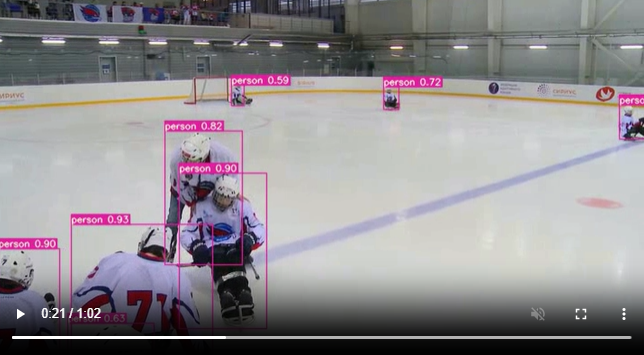 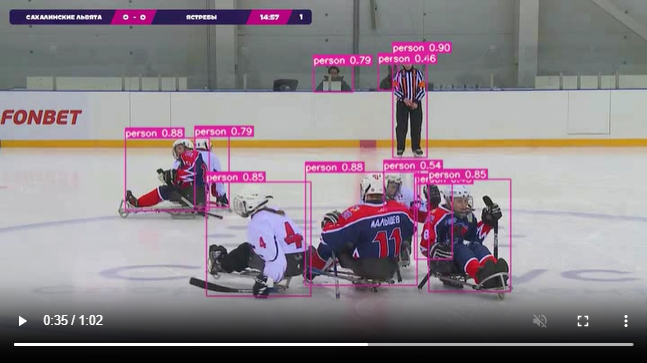

Здесь есть один нюанс связанный с plt.switch_backend. Если просмотр фото запускать сразу после перехода в каталог yolo - фото не отображается. Нужно сначала запустить из главного каталога, а потом использовать конструкцию:

plt.switch_backend('module://matplotlib_inline.backend_inline')
plt.get_backend()

In [10]:
sys.path.append('/home/eugene/develop/yolov7-object-tracking')
from models.experimental import attempt_load
from utils.datasets import letterbox 
from utils.general import non_max_suppression
from utils.download_weights import download
from utils.plots import plot_one_box

In [11]:
#plt.get_backend()
plt.switch_backend('module://matplotlib_inline.backend_inline')
plt.get_backend()

'module://matplotlib_inline.backend_inline'

In [12]:
weights = '/home/eugene/develop/yolov7-object-tracking/yolov7.pt'
model = attempt_load(weights, map_location=device)  
stride = int(model.stride.max())   

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block


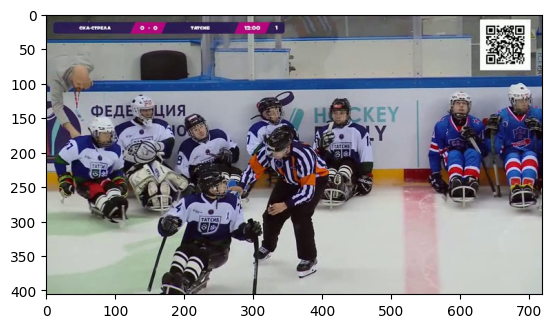

In [17]:
cap = cv2.VideoCapture('/home/eugene/develop/data/output/clear_game.mp4')
cap.set(cv2.CAP_PROP_POS_FRAMES,7850)
_, frame = cap.read()
imshow_frame(frame, pil='yes')

Перед подачей картинки в модель, её размер должен удовлетворять условию кратности каждой стороны шагу stride сетки, по которой модель пробегает для детекции объектов. Сделаем ресайз с помощью паддинга

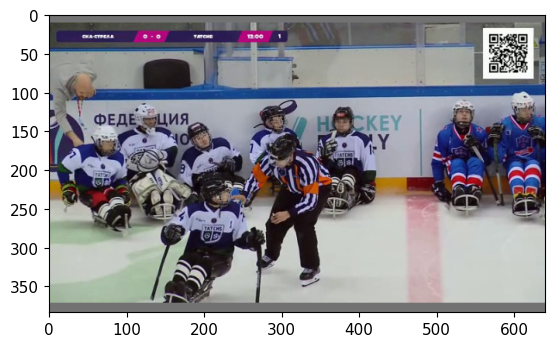

In [14]:
img = letterbox(frame, 640, stride=stride, auto=True)[0]
imshow_frame(img, pil='yes')

Модель делает предсказания на изменённом по размеру изображении, ещё и с отступами по краям, которые были добавлены для выполнения условия кратности размеров шагам сетки с якорями. Чтобы нанести детектированные ключевые точки на исходное изображение, необходимо написать функцию для перевода предсказанных точек в систему координат исходного изображения.

In [15]:
def scale_pose_output(output, resized_shape:tuple, original_shape:tuple, is_padded:bool=True):
    
    scaled_output = output.copy()
    scale_ratio = (resized_shape[1]/original_shape[1], 
                   resized_shape[0]/original_shape[0])      
    if is_padded:
        pad_scale = min(scale_ratio)
        padding = (resized_shape[1] - original_shape[1] * pad_scale)/2, \
                  (resized_shape[0] - original_shape[0] * pad_scale)/2
        scale_ratio = (pad_scale, pad_scale)
        scale_ratio = (pad_scale, pad_scale)       
        scaled_output[:, 0] -= padding[0]     # x_c unpadding
        scaled_output[:, 1] -= padding[1]     # y_c unpadding 
    scaled_output[:, [0, 2]] /= scale_ratio[0]
    scaled_output[:, [1, 3]] /= scale_ratio[1]

    return scaled_output

Отдетектируем людей на отдельно взятом фрейме и получим центры каждого из ббоксов

636 98 719 293 (677, 195)
161 213 313 415 (237, 314)
553 111 641 285 (597, 198)
11 148 121 316 (66, 232)
387 120 476 287 (431, 203)
284 159 412 392 (348, 275)
0 53 70 220 (35, 136)
185 144 283 253 (234, 198)
280 119 365 282 (322, 200)
108 181 209 298 (158, 239)
99 115 187 241 (143, 178)
199 180 286 282 (242, 231)


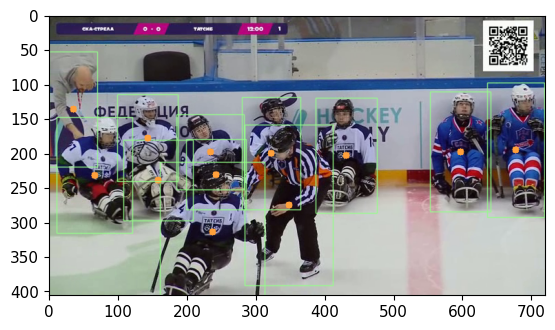

In [16]:
img_ = transforms.ToTensor()(img)
img_ = torch.unsqueeze(img_, 0)
img_ = img_.to(device).float()
with torch.no_grad():
    pred, _ = model(img_)
pred = non_max_suppression(pred, 0.25, 0.45, 0)
pred = scale_pose_output(pred[0].cpu().detach().numpy(), img.shape[0:2], frame.shape[0:2])
bbox = pred[:,:4]
frame_ = frame.copy()
for box in bbox:
    x1, y1, x2, y2 = [int(i) for i in box]
    center = int(x1+(x2-x1)/2), int(y1+(y2-y1)/2)
    print(x1, y1, x2, y2, center)
    plot_one_box(box, frame_, color = (138, 253, 149), line_thickness = 1)
    frame_ = cv2.circle(frame_, center, radius=0, color=(59, 160, 255), thickness=10)

imshow_frame(frame_, pil='yes')

Вырежем отдельного игрока по полученным координатам

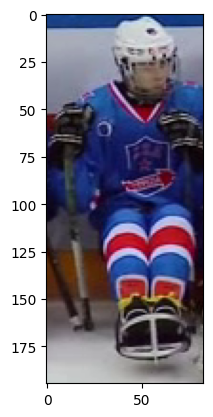

In [18]:
crop_img = frame.copy()
carplate_image = crop_img[98:293,636:719]
imshow_frame(carplate_image, pil='yes')

Запишем все вышесделанное в отдельную функцию

In [18]:
def get_persons_frame(num_frame, frame, dir):
    frame_result = []
    img = letterbox(frame, 640, stride=stride, auto=True)[0]
    img_ = transforms.ToTensor()(img)
    img_ = torch.unsqueeze(img_, 0)
    img_ = img_.to(device).float()
    with torch.no_grad():
        pred, _ = model(img_)
    pred = non_max_suppression(pred, 0.25, 0.45, 0)
    
    pred = scale_pose_output(pred[0].cpu().detach().numpy(), img.shape[0:2], frame.shape[0:2])
    bbox = pred[:,:4]
    for i, box in enumerate(bbox):
        x1, y1, x2, y2 = [int(i) for i in box]
        center = int(x1+(x2-x1)/2), int(y1+(y2-y1)/2)
        crop_img = frame.copy()
        carplate_image = crop_img[y1:y2,x1:x2]
        file_name = f'{num_frame}_{i}.jpg'
        if carplate_image.size!=0:
            cv2.imwrite(dir+file_name, carplate_image)
        frame_result.append([num_frame, file_name, box.tolist(), center])
    return frame_result

Вырежем и сохраним в отдельную папку игроков в каждом 25 фрейме. 

In [19]:
%%time
result_detection = []
cap = cv2.VideoCapture('/home/eugene/develop/data/output/clear_game.mp4')
stop = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
for fr in tqdm.tqdm(range(500, stop, 25)):
    cap.set(cv2.CAP_PROP_POS_FRAMES,fr)
    _, frame = cap.read()
    res = get_persons_frame(fr, frame, '/home/eugene/develop/data/detected_people/')
    result_detection.extend(res)
cap.release()

100%|██████████| 4211/4211 [02:02<00:00, 34.34it/s]

CPU times: user 7min 37s, sys: 18.5 s, total: 7min 55s
Wall time: 2min 2s


In [20]:
import zipfile
 
def zipdir(path, ziph):
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))

zipf = zipfile.ZipFile('detect_people.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('/home/eugene/develop/data/detected_people/', zipf)
zipf.close()

In [23]:
result_detection_df = pd.DataFrame(result_detection, columns = ['frame', 'file_name', 'box', 'point'])
result_detection_df.to_csv('/home/eugene/develop/data/result_detection.csv', ',', encoding = 'utf-8')

## Улучшение качества изображения и распознание

Попробуем распознать на вырезанных с фрейма игроках их номер. Используем тессеракт.

In [25]:
dir_image_detected = Path('/home/eugene/develop/data/detected_people')
list_images = sorted(list(dir_image_detected.rglob('*.jpg')))

In [12]:
def resize_image(img, size): 
    width, height = img.shape[1], img.shape[0]
    if width>height:
        s = size/width
        height_,width_ = int(s*height), size
        img = cv2.resize(img, (size, height_))
    else: 
        s = size/height
        width_, height_ = int(s*width), size
        img = cv2.resize(img, (width_, size))
    return img  

In [ ]:
text_images = []

for image in tqdm.tqdm(list_images):
    low_res_img_ = cv2.imread(str(image))
    low_res_img_ = resize_image(low_res_img_, 80)
    img = cv2.cvtColor(np.array(low_res_img_), cv2.COLOR_BGR2RGB)
    file_name = str(image).split('/')[-1]
    label =  pytesseract.image_to_string(img, lang='eng', config='--psm 12 --oem 1 -c tessedit_char_whitelist=0123456789')
    text_images.append([file_name, label])

 97%|█████████▋| 46744/48035 [2:12:51<03:43,  5.78it/s]  

In [ ]:
text_images_df = pd.DataFrame(text_images, columns = ['file_name', 'label'])
text_images_df.to_csv('/home/eugene/develop/data/tesseract.csv', ',', encoding = 'utf-8')

In [7]:
result_recognition = result_detection_df.merge(text_images_df, on='file_name', how = 'left')
result_recognition['label'] = result_recognition['label'].apply(lambda x: re.sub(r'\D', '', str(x)))
result_recognition.to_csv('/home/eugene/develop/data/result_recognition.csv', ',', encoding = 'utf-8')

In [8]:
result_recognition.loc[result_recognition.label=='4']

Unnamed: 0_x   frame     file_name  \
92               92    1575   1575_10.jpg   
130             130    1675    1675_3.jpg   
151             151    1775    1775_1.jpg   
375             375    2400    2400_3.jpg   
410             410    2475    2475_8.jpg   
...             ...     ...           ...   
34120         34120  100175  100175_6.jpg   
34176         34176  100750  100750_2.jpg   
34295         34295  101525  101525_2.jpg   
34337         34337  101675  101675_3.jpg   
35554         35554  105525  105525_0.jpg   

                                                     box       point  \
92     [670.7654418945312, 233.5575408935547, 685.221...  (677, 252)   
130    [162.74180603027344, 197.0509490966797, 177.34...  (169, 211)   
151    [332.54144287109375, 251.73170471191406, 439.6...  (385, 313)   
375    [423.48638916015625, 168.7532501220703, 503.83...  (463, 242)   
410    [397.62823486328125, 128.61936950683594, 449.4...  (423, 181)   
...                                                  ...         ...   
34120  [387.557861328125, 349.49810791015625, 403.550...  (395, 383)   
34176  [693.1504516601562, 75.53727722167969, 719.883...  (706, 108)   
34295  [78.87804412841797, 155.60340881347656, 126.60...  (102, 188)   
34337  [406.5033874511719, 320.1556396484375, 453.958...  (429, 368)   
35554  [94.67086791992188, 37.457454681396484, 359.52...  (226, 226)   

       Unnamed: 0_y label  
92           4904.0     4  
130          5345.0     4  
151          5799.0     4  
375          8689.0     4  
410          9118.0     4  
...             ...   ...  
34120         167.0     4  
34176         251.0     4  
34295         419.0     4  
34337         465.0     4  
35554        2491.0     4  

[306 rows x 7 columns]

Попробуем улучшить качество изображений с вырезанными игроками. В первую очередь находящихся на удаленных позициях. Для этого будет использовать LDMSuperResolutionPipeline

In [5]:
pipeline = LDMSuperResolutionPipeline.from_pretrained('CompVis/ldm-super-resolution-4x-openimages')
pipeline = pipeline.to(device)

unet/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

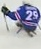

In [6]:
low_res_img_ = Image.open('/home/eugene/develop/data/detected_people/5450_0.jpg').convert('RGB')
low_res_img_

  0%|          | 0/100 [00:00<?, ?it/s]

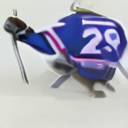

In [7]:
upscaled_image = pipeline(low_res_img_, num_inference_steps=100, eta=0.8).images[0]
upscaled_image

In [8]:
import easyocr

easyocr = easyocr.Reader(['en'])
def easyocr_results(image):
    result = easyocr.readtext(image, text_threshold=0.2, contrast_ths=0.3, min_size=0.4,
                              allowlist = '1234567890')
    return result   

In [9]:
def show_ocr(image, resize):
    #обычная
    low_res_img_ = Image.open(image)
    img = np.array(low_res_img_)
    img_ = cv2.resize(img, (resize, int(img.shape[0] * resize / img.shape[1])),interpolation=cv2.INTER_AREA)  
    #увеличена контрастность
    clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8,8))
    lab = cv2.cvtColor(img_, cv2.COLOR_BGR2LAB) 
    l, a, b = cv2.split(lab)  
    l2 = clahe.apply(l)  
    lab = cv2.merge((l2,a,b))  
    img_2 = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    #в оттенках серого
    gray = cv2.cvtColor(img_, cv2.COLOR_BGR2GRAY)
    #заблюренная
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    #заблюренная с резкостью
    blur_ = cv2.addWeighted(gray,5,blur,-4,0)

    im = [img_, img_2, gray, blur, blur_ ]
    fig, ax = plt.subplots(nrows=1, ncols=len(im), figsize=(12, 6))
    for i, fig_x in enumerate(ax.flatten()):
        text = pytesseract.image_to_string(im[i], config='--psm 6 --oem 3 -c tessedit_char_whitelist=0123456789 min_characters_to_try=1 -alpha off -dpi 7')
        text_easy = easyocr_results(im[i])[0][1] if len(easyocr_results(im[i]))>0 else ''
        text = ''.join([x for x in text if x.isdigit()])
        text_full = f'easy: {text_easy} tes: {text}'
        if i>1:
            imshow_frame(im[i], title = text_full, plt_ax=fig_x, pil = 'yes')
        else:
            imshow_frame(im[i], title = text_full, plt_ax=fig_x)

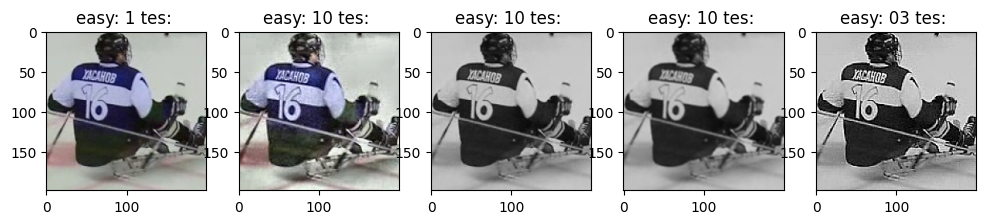

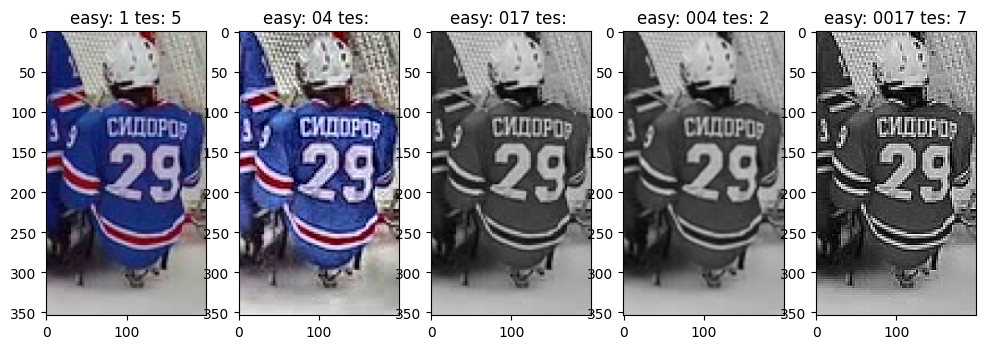

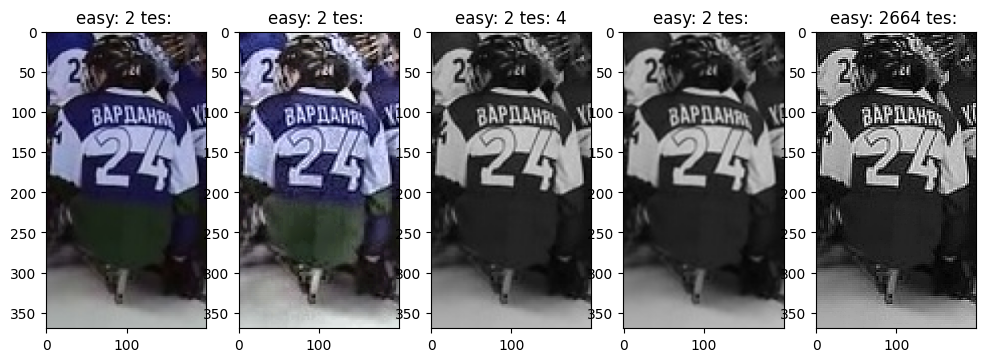

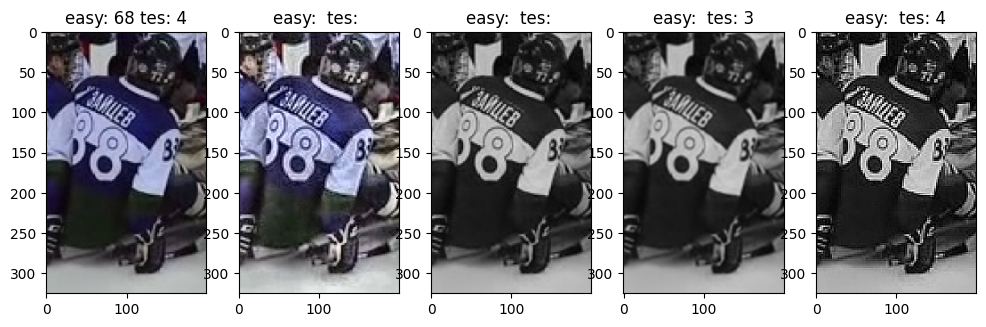

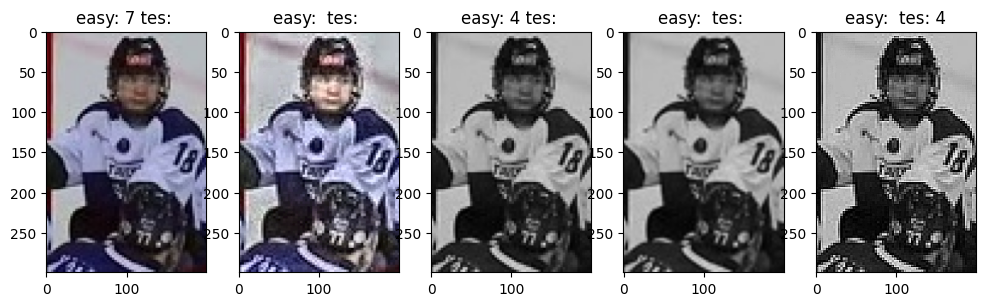

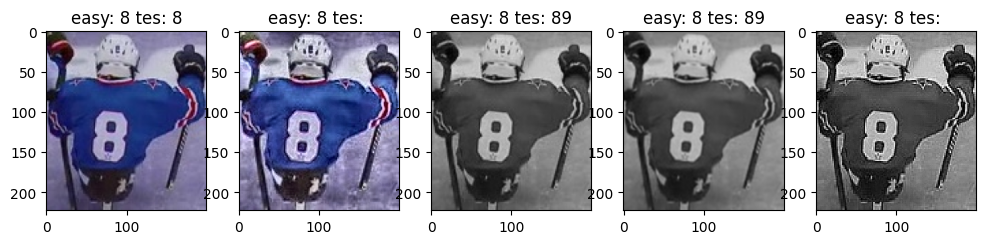

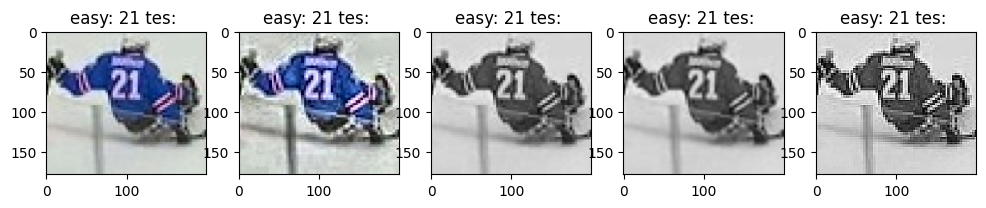

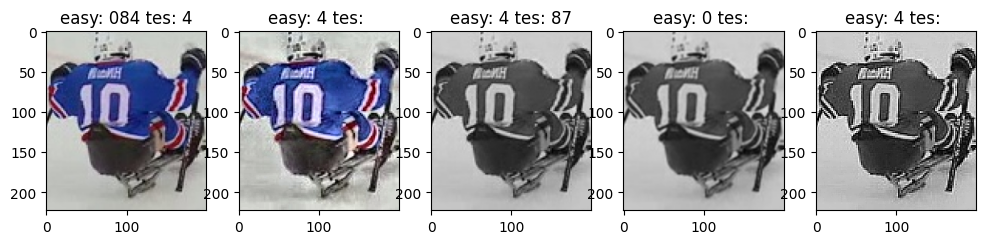

In [10]:
list_player_number = ['6750_3', '1800_2','2250_1', '2200_5', '2350_1', '3350_4','4375_1', '6450_2']
for image in list_player_number:
    filename = f'/home/eugene/develop/data/detected_people/{image}.jpg'
    show_ocr(filename, 200)

    plt.show()

Модель не распознает. Общее наблюдение - более или менее распознается со спины, плохо - с рукавов, шлема гед номера мелкие.
Если есть складки/заломы на форме - номер не читается или читается некорректно.

Кроме тессеракта были протестированы EasyOCR и PaddleOCR - результат хуже

Попробуем TrOCRP

In [11]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


В качестве эксперимента попробуем распознать текст на увеличенных с помощью нейронной сети фото и на обычных.
Буквенные символы исключим из распознаного текста, т.к. у TrOCRP нет whitelist.

Улучшенные

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

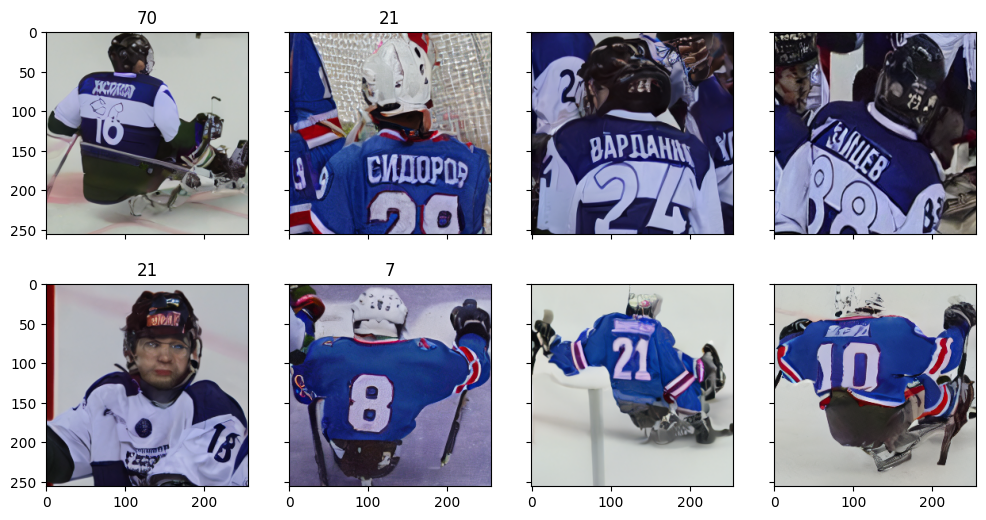

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=4,figsize=(12, 6), sharey=True, sharex=True)
for i, fig_x in enumerate(ax.flatten()):
    low_res_img_ = Image.open(f'/home/eugene/develop/data/detected_people/{list_player_number[i]}.jpg')
    low_res_img_ = low_res_img_.resize((85, int(low_res_img_.size[1] * 85 / low_res_img_.size[0])))
    upscaled_image = pipeline(low_res_img_, num_inference_steps=150, eta=0.8).images[0]
    pixel_values = processor(upscaled_image, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    label =  ''.join([c for c in generated_text if c.isdigit()])
    imshow_frame(np.array(upscaled_image), title=label, plt_ax=fig_x)

Обычные

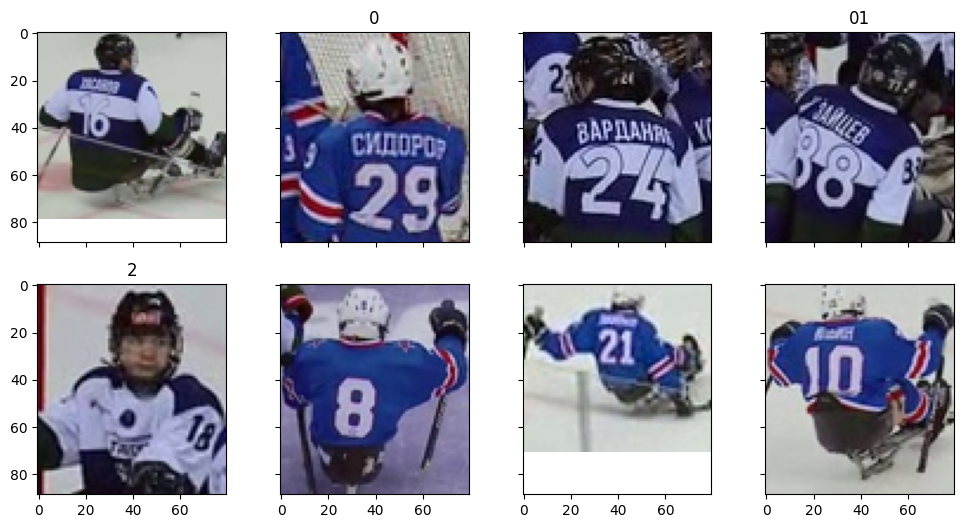

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=4,figsize=(12, 6), sharey=True, sharex=True)
for y, fig_x in enumerate(ax.flatten()):
    low_res_img_ = Image.open(f'/home/eugene/develop/data/detected_people/{list_player_number[y]}.jpg')
    low_res_img_ = low_res_img_.resize((80, int(low_res_img_.size[1]/(low_res_img_.size[0]/80))))
    pixel_values = processor(low_res_img_, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    label =  ''.join([c for c in generated_text if c.isdigit()])
    imshow_frame(np.array(low_res_img_), title=label, plt_ax=fig_x)